## Individual DF Models

#### Overview

Majority of updates in the data.gov csv were made in August 2017

Total number of charge stations = 53301

ev_total (mean) = 2.68 > charge stations per location

evdcfastcount > DC Fast Chargers % of total = 12%

evlevel1evsenum > Level 1 EVSE (standard 110V outlet) % of total = 6%

evlevel2evsenum > Level 2 EVSE (J1772 connector) % of total = 82%


### Import and Format

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Import 2 New DFs Saved Locally in CSV format (data.gov > ev data / cencus.gov > state, city, population

In [29]:
df_ev = pd.read_csv('ev_new.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [30]:
df_ev_pop = pd.read_csv('ev_citystatepop.csv', error_bad_lines=False, index_col=False, dtype='unicode')

In [31]:
df_ev.head(1)

,id,citystate,city,state,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total
0,19458,AbbotsfordWI,Abbotsford,WI,0,1,0,1


In [32]:
# df_ev_drop = df_ev.drop(['id', 'city', 'state'], axis=1)
df_ev_drop = df_ev.drop(['city', 'state'], axis=1)

In [33]:
df_ev_drop.dtypes

id                 object
citystate          object
evdcfastcount      object
evlevel1evsenum    object
evlevel2evsenum    object
ev_total           object
dtype: object

In [77]:
df_ev_drop[('evdcfastcount')] = df_ev_drop[('evdcfastcount')].astype(int)
df_ev_drop[('evlevel1evsenum')] = df_ev_drop[('evlevel1evsenum')].astype(int)
df_ev_drop[('evlevel2evsenum')] = df_ev_drop[('evlevel2evsenum')].astype(int)
df_ev_drop[('ev_total')] = df_ev_drop[('ev_total')].astype(int)
df_ev_drop[('id')] = df_ev_drop[('id')].astype(int)

In [78]:
df_ev_drop.evdcfastcount.fillna(value=0, inplace=True)
df_ev_drop.evlevel1evsenum.fillna(value=0, inplace=True)
df_ev_drop.evlevel2evsenum.fillna(value=0, inplace=True)

In [79]:
df_ev_drop.dtypes

id                  int32
citystate          object
evdcfastcount       int32
evlevel1evsenum     int32
evlevel2evsenum     int32
ev_total            int32
dtype: object

In [63]:
# df_ev_pop['citystate'] = df_ev_pop['citystatepop']

In [37]:
df_ev_pop.head(1)

,citystate,pop
0,AbbevilleAL,2603


In [38]:
df_ev_pop.dtypes

citystate    object
pop          object
dtype: object

In [39]:
df_ev_pop[('citystate')] = df_ev_pop[('citystate')].astype(str)
df_ev_pop[('pop')] = df_ev_pop[('pop')].astype(int)

In [40]:
df_ev_pop.dtypes

citystate    object
pop           int32
dtype: object

#### Set index of both DFs to 'citystate' to merge on

In [80]:
# df.set_index('Locality', inplace=True)
df_ev_drop2 = df_ev_drop.set_index('citystate')

In [81]:
df_ev_drop2 .head()

,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total
citystate,,,,,
AbbotsfordWI,19458,0,1,0,1
AberdeenMD,19380,0,0,2,2
AberdeenNC,27534,0,0,2,2
AberdeenNC,27574,0,0,4,4
AberdeenNC,27586,0,0,4,4


In [82]:
df_ev_pop2 = df_ev_pop.set_index('citystate')

In [83]:
df_ev_pop2.head(1)

,pop
citystate,
AbbevilleAL,2603


#### Merge on 'citystate' to introduce population into the data set

In [84]:
df_ev_merge = pd.merge(df_ev_drop2, df_ev_pop2, right_index=True, left_index=True)

In [85]:
df_ev_merge.head()

,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total,pop
citystate,,,,,,
AbbotsfordWI,19458,0,1,0,1,2259
AberdeenMD,19380,0,0,2,2,15612
AberdeenNC,27534,0,0,2,2,7502
AberdeenNC,27574,0,0,4,4,7502
AberdeenNC,27586,0,0,4,4,7502


In [86]:
df_ev_merge.isnull().sum()

id                 0
evdcfastcount      0
evlevel1evsenum    0
evlevel2evsenum    0
ev_total           0
pop                0
dtype: int64

In [88]:
df_ev_merge.shape

(16617, 6)

In [93]:
df_ev_grouped = df_ev_merge.groupby(['citystate', 'pop']).sum()

In [127]:

# IMPORTANT > 'pop' and 'id' are now a sub DFs. 
# Must add a new column that converts it them to int before they can be used in a model (pop_x) / (id_x)


In [112]:
df_ev_grouped.head()

,,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total
citystate,pop,,,,,
AbbotsfordWI,2259,19458,0,1,0,1
AberdeenMD,15612,19380,0,0,2,2
AberdeenNC,7502,82694,0,0,10,10
AberdeenSD,28415,53098,0,0,6,6
AberdeenWA,16334,25517,8,0,0,8


In [95]:
df_ev_grouped.shape

(2957, 5)

In [200]:
# ev_total zeros removal (just in case there are any)
df_ev_final = df_ev_grouped[df_ev_grouped.ev_total != 0]

In [201]:
df_ev_final.shape

(2957, 5)

### Final DF Config and Checks

In [202]:
# Reset index for use in model
df_ev_final = df_ev_grouped.reset_index()

In [203]:
df_ev_final.head()

,citystate,pop,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total
0,AbbotsfordWI,2259,19458,0,1,0,1
1,AberdeenMD,15612,19380,0,0,2,2
2,AberdeenNC,7502,82694,0,0,10,10
3,AberdeenSD,28415,53098,0,0,6,6
4,AberdeenWA,16334,25517,8,0,0,8


In [ ]:

# Conversion of 'pop' and 'id' as a new int columns


In [204]:
df_ev_final[('pop_x')] = df_ev_final[('pop')].astype(int)
df_ev_final[('id_x')] = df_ev_final[('id')].astype(int)

In [205]:
df_ev_final.pop_x.dtype

dtype('int32')

In [206]:
df_ev_final.id_x.dtype

dtype('int32')

In [207]:
df_ev_final.head()

,citystate,pop,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,ev_total,pop_x,id_x
0,AbbotsfordWI,2259,19458,0,1,0,1,2259,19458
1,AberdeenMD,15612,19380,0,0,2,2,15612,19380
2,AberdeenNC,7502,82694,0,0,10,10,7502,82694
3,AberdeenSD,28415,53098,0,0,6,6,28415,53098
4,AberdeenWA,16334,25517,8,0,0,8,16334,25517


In [208]:
df_ev_final.shape

(2957, 9)

In [209]:
df_ev_final.isnull().sum()

citystate          0
pop                0
id                 0
evdcfastcount      0
evlevel1evsenum    0
evlevel2evsenum    0
ev_total           0
pop_x              0
id_x               0
dtype: int64

In [210]:
df_ev_final.nunique()

citystate          2953
pop                2873
id                 2925
evdcfastcount        33
evlevel1evsenum      39
evlevel2evsenum     141
ev_total            149
pop_x              2873
id_x               2925
dtype: int64

In [211]:
df_ev_final.evlevel2evsenum.value_counts()

2       706
1       433
4       279
0       236
3       207
6       134
5       123
8        79
10       73
7        70
9        59
11       38
12       36
14       32
15       31
13       29
16       25
20       22
18       20
19       19
17       17
22       13
21       12
26       11
23       11
24       11
28       10
30        9
31        7
25        7
       ... 
527       1
535       1
665       1
121       1
103       1
174       1
314       1
178       1
180       1
182       1
192       1
196       1
202       1
256       1
282       1
296       1
304       1
334       1
99        1
430       1
506       1
514       1
785       1
55        1
61        1
67        1
77        1
83        1
89        1
1626      1
Name: evlevel2evsenum, Length: 141, dtype: int64

### Features Setup

In [212]:
df_ev_final.columns

Index([u'citystate', u'pop', u'id', u'evdcfastcount', u'evlevel1evsenum',
       u'evlevel2evsenum', u'ev_total', u'pop_x', u'id_x'],
      dtype='object')

#### Individual DFs for each charger type

#### Fast DF

In [147]:
df_ev_final.columns

Index([u'citystate', u'pop', u'id', u'evdcfastcount', u'evlevel1evsenum',
       u'evlevel2evsenum', u'ev_total', u'pop_x', u'id_x'],
      dtype='object')

In [213]:
df_ev1 = df_ev_final[df_ev_final.evdcfastcount != 0]

In [214]:
df_ev_fast = df_ev1.drop(['citystate', 'pop', 'id', 'pop_x', 'id_x', 'ev_total', 'evlevel1evsenum', 'evlevel2evsenum'], axis=1)

In [215]:
df_ev_fast[('pop_fast')] = df_ev_final[('pop_x')].astype(int)
df_ev_fast[('id_fast')] = df_ev_final[('id_x')].astype(int)

In [216]:
features_fast = ['pop_fast', 'id_fast']

In [217]:
fast_y = df_ev_fast.evdcfastcount

In [218]:
df_ev_fast.head()

,evdcfastcount,pop_fast,id_fast
4,8,16334,25517
14,2,197633,202759
15,8,78906,155138
19,8,98111,377406
20,2,53211,61590


In [219]:
df_ev_fast.shape

(1042, 3)

#### 110 DF

In [220]:
df_ev2 = df_ev_final[df_ev_final.evlevel1evsenum != 0]

In [221]:
df_ev_110 = df_ev2.drop(['citystate', 'pop', 'id', 'pop_x', 'id_x', 'ev_total', 'evdcfastcount', 'evlevel2evsenum'], axis=1)

In [222]:
df_ev_110[('pop_110')] = df_ev_final[('pop_x')].astype(int)
df_ev_110[('id_110')] = df_ev_final[('id_x')].astype(int)

In [223]:
features_110 = ['pop_110', 'id_110']

In [224]:
y_110 = df_ev_110.evlevel1evsenum

In [225]:
df_ev_110.head()

,evlevel1evsenum,pop_110,id_110
0,1,2259,19458
19,4,98111,377406
21,1,17667,50134
24,1,8337,12233
25,1,1599,10854


In [162]:
df_ev_110.shape

(551, 3)

#### 220 DF

In [226]:
df_ev3 = df_ev_final[df_ev_final.evlevel2evsenum != 0]

In [227]:
df_ev_220 = df_ev3.drop(['citystate', 'pop', 'id', 'pop_x', 'id_x', 'ev_total', 'evdcfastcount', 'evlevel1evsenum'], axis=1)

In [228]:
df_ev_220[('pop_110')] = df_ev_final[('pop_x')].astype(int)
df_ev_220[('id_110')] = df_ev_final[('id_x')].astype(int)

In [229]:
features_220 = ['pop_x', 'id_x']

In [230]:
y_220 = df_ev_220.evlevel2evsenum

In [231]:
df_ev_220.head()

,evlevel2evsenum,pop_x,id_x,pop_110,id_110
1,2,15612,19380,15612,19380
2,10,7502,82694,7502,82694
3,6,28415,53098,28415,53098
5,3,122225,35420,122225,35420
6,1,8083,22169,8083,22169


In [169]:
df_ev_220.shape

(2721, 3)

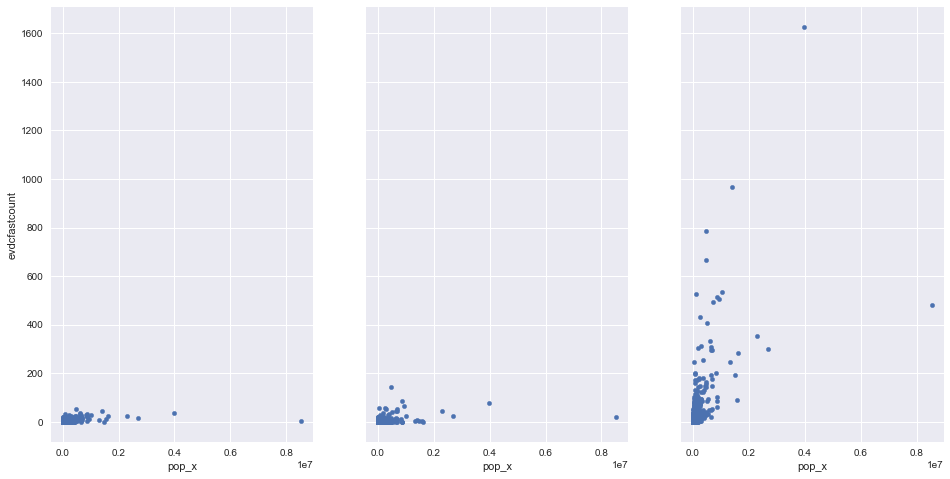

In [170]:
fig, axs = plt.subplots(1, 3, sharey=True)
sns.set(font_scale = 1)
df_ev_final.plot(kind='scatter', x='pop_x', y='evdcfastcount', ax=axs[0], figsize=(16, 8))
df_ev_final.plot(kind='scatter', x='pop_x', y='evlevel1evsenum', ax=axs[1])
df_ev_final.plot(kind='scatter', x='pop_x', y='evlevel2evsenum', ax=axs[2])

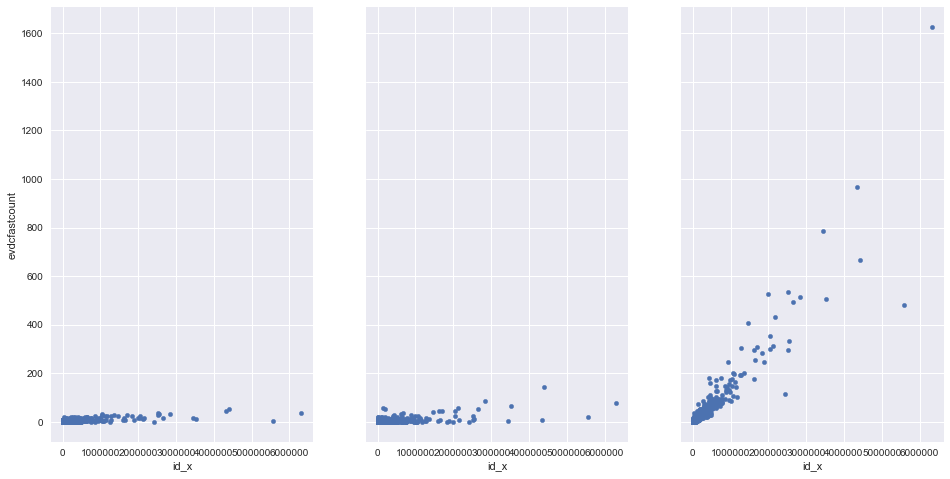

In [171]:
fig, axs = plt.subplots(1, 3, sharey=True)
sns.set(font_scale = 1)
df_ev_final.plot(kind='scatter', x='id_x', y='evdcfastcount', ax=axs[0], figsize=(16, 8))
df_ev_final.plot(kind='scatter', x='id_x', y='evlevel1evsenum', ax=axs[1])
df_ev_final.plot(kind='scatter', x='id_x', y='evlevel2evsenum', ax=axs[2])

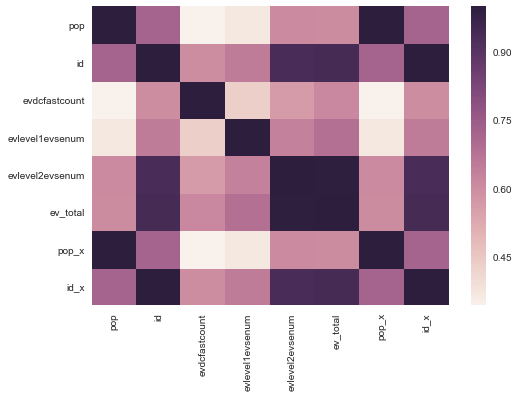

In [172]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(df_ev_final.corr())
sns.set(font_scale = 1.5)

#### Model Build

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import numpy as np
from math import sqrt

In [188]:
features_fast.head()

4       9100
14    196609
15      5122
19     82494
20     49298
dtype: int32

#### Simple LR Model > Fast

In [175]:
# create X and y
X = features_fast
y = fast_y

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

C:\Users\cmagann\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 1042]

In [635]:
# calculate the R-squared
lr.score(X, y)

0.41282743987628168

In [636]:
lr.predict(X)

array([[ 3.98041529],
       [ 4.61553434],
       [ 4.78278834],
       ..., 
       [ 3.86331449],
       [ 3.96327589],
       [ 3.90351526]])

In [637]:
lr.predict(X).mean()

5.0326295585412666

In [638]:
# create X and y
X = df_ev_110x
y = df_ev_110y

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

[('evdcfastcount',
  array([  3.94553889e-02,   6.11297937e-06,  -4.36897073e-06]))]

In [639]:
lr.score(X, y)

0.48220290732931292

In [640]:
lr.predict(X)

array([[  2.22367132],
       [  6.12361648],
       [  2.58060831],
       [  2.19240583],
       [  2.21341416],
       [  3.70929698],
       [  5.18785617],
       [  9.45565855],
       [  2.55225627],
       [  2.20072991],
       [  2.4393246 ],
       [ 12.55605499],
       [  2.14737667],
       [  6.82327547],
       [  4.14952065],
       [  2.13481516],
       [  2.10170312],
       [  1.95829858],
       [  3.32268593],
       [  2.26374444],
       [  9.0742282 ],
       [  3.8875311 ],
       [  3.19126657],
       [  2.32450153],
       [  5.48833489],
       [  2.70552195],
       [ 60.95170893],
       [  2.78200771],
       [ 42.44323122],
       [  2.180983  ],
       [  2.85052301],
       [  2.17564757],
       [ 29.86828778],
       [  2.92654553],
       [  2.90495586],
       [  4.75169866],
       [  2.4209495 ],
       [  4.68109898],
       [  2.55092198],
       [  2.23030017],
       [  2.11243439],
       [  2.18998848],
       [ 15.91919642],
       [  4

In [641]:
lr.predict(X).mean()

5.0399274047186937

In [630]:
# create X and y
X = df_ev_220x
y = df_ev_220y

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

[('evdcfastcount',
  array([  9.33753856e-01,  -9.59446731e-06,   5.70125017e-06]))]

In [631]:
lr.score(X, y)

0.9926051033380705

In [632]:
lr.predict(X)

array([[ 0.93858275],
       [ 7.75491235],
       [ 4.42308503],
       ..., 
       [ 1.83026177],
       [ 1.06218897],
       [ 1.08364779]])

In [633]:
lr.predict(X).mean()

13.804483645718486

In [645]:
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold

In [646]:
# Training setup, with random state
training_data,holdout = train_test_split(df_ev_x,test_size=0.10,random_state=123)

In [647]:
# KFold setup
n = training_data.shape[0]
kf = KFold(X.shape[0],n_folds=6,random_state=1)

In [328]:
# Create model
# lr_model = LinearRegression()

In [648]:
MAE_score = []
MSE_score = []
R2_scores = []
RMSE_score = []

# Use K-Folds cross validation to train your model / kfolds loop (define scores in the loop)
# Fill-in the kfolds-loop:
# use iloc with scikit

for train_index, test_index in kf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_true = y.iloc[train_index], y.iloc[test_index] 
    
    # Fit your model on your training x and training y
    lr.fit(x_train,y_train)
    y_preds = lr.predict(x_test)
    
    fold_score1 = mean_squared_error(y_true,y_preds)
    MSE_score.append(fold_score1)
    
    fold_score2 = mean_absolute_error(y_true,y_preds)
    MAE_score.append(fold_score2)
    
    fold_score3 = r2_score(y_true,y_preds)
    R2_scores.append(fold_score3)
    
    fold_score4 = sqrt(mean_squared_error(y_true,y_preds))
    RMSE_score.append(fold_score4)

In [649]:
lr.predict(x_test)

array([[  4.88992796],
       [  2.79870712],
       [ 36.66983921],
       [  3.22620699],
       [  2.78501913],
       [  2.13873283],
       [  2.81824847],
       [  2.1446486 ],
       [  2.91178268],
       [  1.9388303 ],
       [  2.99502858],
       [  3.30637434],
       [  5.07099236],
       [  2.73558246],
       [ 10.97419236],
       [  2.30046527],
       [  2.84408213],
       [  2.21285462],
       [  4.85180034],
       [  2.3657422 ],
       [  2.20636455],
       [  5.1517932 ],
       [  2.02126039],
       [  5.28951822],
       [  2.03952027],
       [  4.94458331],
       [  2.23127885],
       [  2.29727607],
       [ 11.18965677],
       [  3.01253617],
       [  2.2563703 ],
       [  2.64455957],
       [  2.52711322],
       [  7.89910621],
       [ 11.93132379],
       [  2.78523054],
       [  2.14183221],
       [ 10.84563286],
       [  2.74432357],
       [  2.7571261 ],
       [  2.68021117],
       [  3.03949568],
       [  2.85835061],
       [  8

In [664]:
lr.predict(x_test).mean()

3.7694724354118154

In [694]:
R2_scores.predict(x_test)

AttributeError: 'list' object has no attribute 'predict'

In [665]:
y_preds.mean()

3.7694724354118154

In [674]:
y_true.mean()

evlevel1evsenum    4.318681
dtype: float64

In [675]:
x_test.mean()

ev_total        29.109890
id          152599.934066
pop_y        70810.483516
dtype: float64

In [668]:
# mean squared error
MSE_score

[153.42353263519081,
 27.59693961059223,
 100.54004519177397,
 19.967855619366581,
 116.93022230991095,
 36.715598676922575]

In [676]:
# mean absolute error
MAE_score

[4.3465640684164564,
 2.7749873841717165,
 4.2205373754249944,
 2.7457991559030597,
 5.1086303525043455,
 2.5052031224055549]

In [677]:
# root squared mean error
RMSE_score

[12.386425337246854,
 5.253278938966808,
 10.026965901596254,
 4.468540658801997,
 10.813427870472477,
 6.059339788865002]

In [678]:
# root squared
R2_scores

[0.43444832237969078,
 0.32652353078744345,
 -0.060992233051192501,
 0.11240458816812737,
 0.36083689987898282,
 0.45846833073838389]

In [681]:
# normalize view
lr.intercept_

array([ 2.02565615])

In [682]:
list(lr.predict(x_test)[0:5]) 

[array([ 4.88992796]),
 array([ 2.79870712]),
 array([ 36.66983921]),
 array([ 3.22620699]),
 array([ 2.78501913])]

In [ ]:
# Holdout Testing

In [683]:
# Training setup
training_data = holdout

In [684]:
holdout.head(1)

,ev_total,id,evdcfastcount,evlevel1evsenum,evlevel2evsenum,pop_y
343,5,41810,2,0,3,45016


In [686]:
X = holdout[feature_cols]
y = holdout.df_ev_x,test

KeyError: "['ev_total_mean'] not in index"

In [688]:
lr.predict(X)

array([[  2.18196224],
       [  6.08188389],
       [  2.53246448],
       [  2.14143081],
       [  2.16280959],
       [  3.5982078 ],
       [  5.2880701 ],
       [  9.40851491],
       [  2.52070503],
       [  2.15806819],
       [  2.38261028],
       [ 12.1928388 ],
       [  2.09040403],
       [  6.67278308],
       [  4.13339757],
       [  2.08161506],
       [  2.05166741],
       [  1.90278829],
       [  3.28656201],
       [  2.21981861],
       [  9.07964474],
       [  3.83286887],
       [  3.17096744],
       [  2.28137274],
       [  5.52875983],
       [  2.6595084 ],
       [ 60.29852466],
       [  2.75586935],
       [ 42.19698834],
       [  2.12704502],
       [  2.78841849],
       [  2.12395647],
       [ 29.84591513],
       [  2.8708498 ],
       [  2.78690461],
       [  4.74437385],
       [  2.35962855],
       [  4.63318125],
       [  2.50463237],
       [  2.18576538],
       [  2.06079804],
       [  2.11662822],
       [ 15.6620767 ],
       [  4

In [ ]:
Grid Search

In [691]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=lr.Ridge(),
    param_grid={'alpha': alphas},
    scoring='neg_mean_squared_error')

gs.fit(X, y)

AttributeError: 'LinearRegression' object has no attribute 'Ridge'

In [692]:
print(gs.best_score_)

NameError: name 'gs' is not defined

In [295]:
print(-gs.best_score_)

1.29206607478e-26


In [296]:
print(gs.best_estimator_)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [300]:
lm = linear_model.LinearRegression().fit(X, y)
print("~~~ OLS ~~~")
print('OLS MSE: ', metrics.mean_squared_error(y, lm.predict(X)))
print('OLS R2:', lm.score(X, y))

lm = linear_model.Lasso().fit(X, y)
print("~~~ Lasso ~~~")
print('Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(X)))
print('Lasso R2:', lm.score(X, y))

lm = linear_model.Ridge().fit(X, y)
print("~~~ Ridge ~~~")
print('Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(X)))
print('Ridge R2:', lm.score(X, y))

~~~ OLS ~~~
('OLS MSE: ', 1.50578748205746e-29)
('OLS R2:', 1.0)
~~~ Lasso ~~~
('Lasso MSE: ', 1.2043941989012539)
('Lasso R2:', 0.88605520527553772)
~~~ Ridge ~~~
('Ridge MSE: ', 3.0612476896618743e-07)
('Ridge R2:', 0.99999997103828286)


In [315]:
# create X and y
feature_cols = ['evdcfastcount']
X = df_final[feature_cols]
y = df_final.ev_total_mean

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

[('evdcfastcount', 0.2022868039030801)]

In [316]:
# Fast charger (looking strong)
lr.predict(X)

array([ 0.37593849,  0.7805121 ,  0.37593849, ...,  1.99423292,
        1.99423292,  1.99423292])

In [318]:
# create X and y
feature_cols = ['evlevel1evsenum']
X = df_final[feature_cols]
y = df_final.ev_total_mean

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

[('evlevel1evsenum', 0.38323903669674492)]

In [319]:
# Simple 110 outlet (dying out)
lr.predict(X)

array([ 0.37639861,  0.37639861,  8.80765741, ...,  0.37639861,
        0.37639861,  0.37639861])

In [320]:
# create X and y
feature_cols = ['evlevel2evsenum']
X = df_final[feature_cols]
y = df_final.ev_total_mean

# instantiate, fit
lr = LinearRegression()
lr.fit(X, y)

# print coefficients
zip(feature_cols, lr.coef_)

[('evlevel2evsenum', 0.33297365580972665)]

In [321]:
# Simple J1772 220 outlet (not looking too strong)
lr.predict(X)

array([ 1.03877995,  0.7058063 ,  7.03230576, ..., -0.29311467,
       -0.29311467, -0.29311467])

In [ ]:
# OUTCOME
# Recommend 2 Super Chargers at individual locations (good for consumers and future compensation)